In [1]:
import matplotlib.pyplot as plt
import numpy as np

from commpy.modulation import QAMModem

from optic.dsp import pulseShape, firFilter, decimate, symbolSync, resample
from optic.models import phaseNoise, KramersKronigRx, linFiberCh

from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from optic.plot import pconst

import scipy.constants as const

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

### Simulation of a single polarization optical signal transmission

In [2]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 64                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 600000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
#paramTx.alphaRRC = 0.91        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 50      # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16           # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
#FO = 5e9 + paramTx.Rs/2  # frequency offset
lw = 0*200e3       # linewidth
ϕ_lo = 0           # initial phase in rad
Plo_dBm = 12       # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

In [3]:
plt.rcParams['font.size'] = 13
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['text.usetex'] = False

### Neural Network Performance Analysis

In [4]:
FO_Values = np.arange(1e9, 6e9, 1e9)
Rolloff = np.arange(0.01, 0.99, 0.1)

BER_NN = np.zeros((FO_Values.size, Rolloff.size))
SER_NN = np.zeros((FO_Values.size, Rolloff.size))
GMI_NN = np.zeros((FO_Values.size, Rolloff.size))
MI_NN  = np.zeros((FO_Values.size, Rolloff.size))
SNR_NN = np.zeros((FO_Values.size, Rolloff.size))

N = 256  # number of input amplitude samples to the NN

for indNN, FO_ in enumerate(FO_Values):
    for index, indRoll_ in enumerate(Rolloff):
        
        # Main simulation parameters
        paramTx.alphaRRC = indRoll_
        FO = FO_ + paramTx.Rs/2
        # get the model according to the simulation parameters
        modelNN = tf.keras.models.load_model('NN_models/testModel_SpS_'+str(paramADC.SpS_out)+'_FO_'+str(FO/10e9)+'GHz_Rolloff_'+str(round(paramTx.alphaRRC, 2)))
        
        # generate optical signal signal
        sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

        # simulate linear signal propagation
        sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

        # receiver detection and demodulation
        Fc = paramTx.Fc
        Ts = 1 / Fs
        mod = QAMModem(m=paramTx.M)

        freqGrid = paramTx.freqGrid
        print(
            "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
            % (
                chIndex,
                (Fc + freqGrid[chIndex]) / 1e12,
                const.c / (Fc + freqGrid[chIndex]) / 1e-9,
            )
        )

        symbTx = symbTx_[:, :, chIndex]

        Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

        print(
            "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
            % (Plo_dBm, lw / 1e3, FO / 1e6)
        )

        # generate LO field
        π = np.pi
        t = np.arange(0, len(sigCh))*Ts
        ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

        sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

        # Add LO to the received signal
        sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
        sfm = sigRx.copy()

        print('CSPR = %.2f dB' % (10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

        # ### Phase-retrieval stage

        # In[4]:

        # resampling to ADC sampling rate
        sigCh = resample(sigCh, paramADC)
        sfm = resample(sfm, paramADC)
        newFs = paramADC.SpS_out*paramTx.Rs

        # simulate ideal direct-detection optical receiver
        Amp = np.abs(sigRx)
        Amp = resample(Amp, paramADC)

        sfm = sfm/np.sqrt(signal_power(sfm))

        sigPhase = np.angle(sfm)  # get signal phase samples (labels) (L,)
        sigAmp   = np.pad(np.abs(sfm), (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

        # create set of input features
        X_input = np.zeros((len(sigPhase), N))  # (L,N)

        for indPhase in range(len(sigPhase)):
            X_input[indPhase] = sigAmp[indPhase:N+indPhase]

        phiTime_NN = modelNN.predict(X_input)
        phiTime_NN = phiTime_NN.reshape(-1,)

        # optical field reconstruction
        sigRx = np.abs(sfm)*np.exp(1j*phiTime_NN)

        # remove DC level
        sigRx -= np.mean(sigRx)  # np.sqrt(Plo)

        # downshift to baseband
        t = np.arange(0, len(sigRx))*(1/newFs)
        sigRx *= np.exp(-1j * (2 * π * FO * t))

        # correct for (possible) phase ambiguity
        rot = np.mean(sigCh/sigRx)
        sigRx = rot * sigRx
        sigRx = sigRx / np.sqrt(signal_power(sigRx))

        # #### Standard receiver processing

        # In[5]:

        # resample to 2 samples/symbol:
        paramRes = parameters()
        paramRes.Rs = paramTx.Rs
        paramRes.SpS_in = paramADC.SpS_out
        paramRes.SpS_out = 2

        sigRx = resample(sigRx, paramRes)

        # Matched filtering and CD compensation

        # Matched filtering
        if paramTx.pulse == "nrz":
            pulse = pulseShape("nrz", paramADC.SpS_out)
        elif paramTx.pulse == "rrc":
            pulse = pulseShape(
                "rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
            )

        pulse = pulse / np.max(np.abs(pulse))
        sigRx = firFilter(pulse, sigRx)

        # plot constellations after matched filtering
        #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

        # CD compensation
        sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

        #plot constellations after CD compensation
        #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

        # Downsampling to 2 sps and re-synchronization with transmitted sequences
        sigRx = sigRx.reshape(-1, 1)

        symbRx = symbolSync(sigRx, symbTx, 2)

        # In[6]:

        # Power normalization
        x = sigRx
        d = symbRx

        x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
        d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

        # Adaptive equalization
        mod = QAMModem(m=paramTx.M)

        paramEq = parameters()
        paramEq.nTaps = 15
        paramEq.SpS = 2
        paramEq.mu = [5e-3, 2e-3]
        paramEq.numIter = 5
        paramEq.storeCoeff = False
        paramEq.alg = ["nlms", "dd-lms"]
        paramEq.M = paramTx.M
        paramEq.L = [20000, 80000]

        y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

        discard = int(paramEq.L[0]/2)

        #plot constellations after adaptive equalization
        #pconst(y_EQ[discard:-discard, :], lim=True)

        # In[7]:

        # Carrier phase recovery
        paramCPR = parameters()
        paramCPR.alg = "bps"
        paramCPR.M = paramTx.M
        paramCPR.N = 75
        paramCPR.B = 64
        paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

        y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

        y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

        discard = 5000

        # plot constellations after CPR
        #pconst(y_CPR[discard:-discard, :], lim=True)

        # #### Evaluate transmission metrics

        # In[8]:

        # correct for (possible) phase ambiguity
        for k in range(y_CPR.shape[1]):
            rot = np.mean(d[:, k] / y_CPR[:, k])
            y_CPR[:, k] = rot * y_CPR[:, k]

        y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

        ind = np.arange(discard, d.shape[0] - discard)
        BER_NN[indNN][index], SER_NN[indNN][index], SNR_NN[indNN][index] = fastBERcalc(y_CPR[ind, :], d[ind, :], mod)
        GMI_NN[indNN][index], _ = monteCarloGMI(y_CPR[ind, :], d[ind, :], mod)
        MI_NN[indNN][index] = monteCarloMI(y_CPR[ind, :], d[ind, :], mod)

        print("Results:\n")
        print("SER: %.2e" % (SER_NN[indNN][index]))
        print("BER: %.2e" % (BER_NN[indNN][index]))
        print("SNR: %.2f dB" % (SNR_NN[indNN][index]))
        print("MI: %.2f bits" % (MI_NN[indNN][index]))
        print("GMI: %.2f bits" % (GMI_NN[indNN][index]))


channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022210.
nlms pre-convergence training iteration #1
nlms MSE = 0.002716.
nlms pre-convergence training iteration #2
nlms MSE = 0.002310.
nlms pre-convergence training iteration #3
nlms MSE = 0.002077.
nlms pre-convergence training iteration #4
nlms MSE = 0.001924.


dd-lms - training stage #1
dd-lms MSE = 0.001096.
Results:

SER: 1.33e-04
BER: 3.15e-05
SNR: 29.50 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.021285.
nlms pre-convergence training iteration #1
nlms MSE = 0.003849.
nlms pre-convergence training iteration #2
nlms MSE = 0.003329.
nlms pre-convergence training iteration #3
nlms MSE = 0.003052.
nlms pre-convergence training iteration #4
nlms MSE = 0.002883.


dd-lms - training stage #1
dd-lms MSE = 0.001330.
Results:

SER: 3.11e-04
BER: 7.22e-05
SNR: 28.65 dB
MI: 6.00 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022467.
nlms pre-convergence training iteration #1
nlms MSE = 0.005410.
nlms pre-convergence training iteration #2
nlms MSE = 0.004855.
nlms pre-convergence training iteration #3
nlms MSE = 0.004517.
nlms pre-convergence training iteration #4
nlms MSE = 0.004290.


dd-lms - training stage #1
dd-lms MSE = 0.002901.
Results:

SER: 1.00e-03
BER: 2.26e-04
SNR: 25.37 dB
MI: 6.00 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.026489.
nlms pre-convergence training iteration #1
nlms MSE = 0.008963.
nlms pre-convergence training iteration #2
nlms MSE = 0.007700.
nlms pre-convergence training iteration #3
nlms MSE = 0.006894.
nlms pre-convergence training iteration #4
nlms MSE = 0.006333.


dd-lms - training stage #1
dd-lms MSE = 0.004058.
Results:

SER: 5.76e-03
BER: 1.39e-03
SNR: 23.66 dB
MI: 5.97 bits
GMI: 5.96 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.030861.
nlms pre-convergence training iteration #1
nlms MSE = 0.011835.
nlms pre-convergence training iteration #2
nlms MSE = 0.009599.
nlms pre-convergence training iteration #3
nlms MSE = 0.008279.
nlms pre-convergence training iteration #4
nlms MSE = 0.007432.


dd-lms - training stage #1
dd-lms MSE = 0.004710.
Results:

SER: 1.02e-02
BER: 2.57e-03
SNR: 22.94 dB
MI: 5.95 bits
GMI: 5.92 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.034892.
nlms pre-convergence training iteration #1
nlms MSE = 0.014273.
nlms pre-convergence training iteration #2
nlms MSE = 0.011201.
nlms pre-convergence training iteration #3
nlms MSE = 0.009545.
nlms pre-convergence training iteration #4
nlms MSE = 0.008559.


dd-lms - training stage #1
dd-lms MSE = 0.006010.
Results:

SER: 2.16e-02
BER: 5.62e-03
SNR: 21.85 dB
MI: 5.90 bits
GMI: 5.84 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.039795.
nlms pre-convergence training iteration #1
nlms MSE = 0.019979.
nlms pre-convergence training iteration #2
nlms MSE = 0.016746.
nlms pre-convergence training iteration #3
nlms MSE = 0.014959.
nlms pre-convergence training iteration #4
nlms MSE = 0.013902.


dd-lms - training stage #1
dd-lms MSE = 0.009910.
Results:

SER: 9.62e-02
BER: 2.53e-02
SNR: 19.07 dB
MI: 5.59 bits
GMI: 5.38 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.043746.
nlms pre-convergence training iteration #1
nlms MSE = 0.024821.
nlms pre-convergence training iteration #2
nlms MSE = 0.020916.
nlms pre-convergence training iteration #3
nlms MSE = 0.018795.
nlms pre-convergence training iteration #4
nlms MSE = 0.017545.


dd-lms - training stage #1
dd-lms MSE = 0.011603.
Results:

SER: 1.50e-01
BER: 4.04e-02
SNR: 17.88 dB
MI: 5.37 bits
GMI: 5.05 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.050175.
nlms pre-convergence training iteration #1
nlms MSE = 0.029603.
nlms pre-convergence training iteration #2
nlms MSE = 0.025113.
nlms pre-convergence training iteration #3
nlms MSE = 0.022689.
nlms pre-convergence training iteration #4
nlms MSE = 0.021269.


dd-lms - training stage #1
dd-lms MSE = 0.013117.
Results:

SER: 2.13e-01
BER: 5.91e-02
SNR: 16.82 dB
MI: 5.12 bits
GMI: 4.68 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.052147.
nlms pre-convergence training iteration #1
nlms MSE = 0.032777.
nlms pre-convergence training iteration #2
nlms MSE = 0.028390.
nlms pre-convergence training iteration #3
nlms MSE = 0.025907.
nlms pre-convergence training iteration #4
nlms MSE = 0.024407.


dd-lms - training stage #1
dd-lms MSE = 0.014278.
Results:

SER: 2.91e-01
BER: 8.29e-02
SNR: 15.69 dB
MI: 4.81 bits
GMI: 4.25 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022895.
nlms pre-convergence training iteration #1
nlms MSE = 0.002781.
nlms pre-convergence training iteration #2
nlms MSE = 0.002363.
nlms pre-convergence training iteration #3
nlms MSE = 0.002121.
nlms pre-convergence training iteration #4
nlms MSE = 0.001963.


dd-lms - training stage #1
dd-lms MSE = 0.001473.
Results:

SER: 3.67e-04
BER: 7.78e-05
SNR: 28.16 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020481.
nlms pre-convergence training iteration #1
nlms MSE = 0.003011.
nlms pre-convergence training iteration #2
nlms MSE = 0.002540.
nlms pre-convergence training iteration #3
nlms MSE = 0.002292.
nlms pre-convergence training iteration #4
nlms MSE = 0.002141.


dd-lms - training stage #1
dd-lms MSE = 0.000897.
Results:

SER: 1.56e-04
BER: 3.70e-05
SNR: 30.34 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.018229.
nlms pre-convergence training iteration #1
nlms MSE = 0.003323.
nlms pre-convergence training iteration #2
nlms MSE = 0.003094.
nlms pre-convergence training iteration #3
nlms MSE = 0.002939.
nlms pre-convergence training iteration #4
nlms MSE = 0.002829.


dd-lms - training stage #1
dd-lms MSE = 0.001449.
Results:

SER: 4.22e-04
BER: 8.52e-05
SNR: 28.30 dB
MI: 6.00 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.018437.
nlms pre-convergence training iteration #1
nlms MSE = 0.003922.
nlms pre-convergence training iteration #2
nlms MSE = 0.003613.
nlms pre-convergence training iteration #3
nlms MSE = 0.003384.
nlms pre-convergence training iteration #4
nlms MSE = 0.003204.


dd-lms - training stage #1
dd-lms MSE = 0.001819.
Results:

SER: 1.44e-04
BER: 2.96e-05
SNR: 27.22 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.021502.
nlms pre-convergence training iteration #1
nlms MSE = 0.006178.
nlms pre-convergence training iteration #2
nlms MSE = 0.005217.
nlms pre-convergence training iteration #3
nlms MSE = 0.004575.
nlms pre-convergence training iteration #4
nlms MSE = 0.004121.


dd-lms - training stage #1
dd-lms MSE = 0.002697.
Results:

SER: 1.28e-03
BER: 2.94e-04
SNR: 25.49 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.025899.
nlms pre-convergence training iteration #1
nlms MSE = 0.009206.
nlms pre-convergence training iteration #2
nlms MSE = 0.007273.
nlms pre-convergence training iteration #3
nlms MSE = 0.006138.
nlms pre-convergence training iteration #4
nlms MSE = 0.005425.


dd-lms - training stage #1
dd-lms MSE = 0.003500.
Results:

SER: 2.82e-03
BER: 6.87e-04
SNR: 24.30 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.029093.
nlms pre-convergence training iteration #1
nlms MSE = 0.011029.
nlms pre-convergence training iteration #2
nlms MSE = 0.008373.
nlms pre-convergence training iteration #3
nlms MSE = 0.006952.
nlms pre-convergence training iteration #4
nlms MSE = 0.006130.


dd-lms - training stage #1
dd-lms MSE = 0.004331.
Results:

SER: 7.10e-03
BER: 1.79e-03
SNR: 23.42 dB
MI: 5.96 bits
GMI: 5.94 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.032998.
nlms pre-convergence training iteration #1
nlms MSE = 0.017046.
nlms pre-convergence training iteration #2
nlms MSE = 0.014584.
nlms pre-convergence training iteration #3
nlms MSE = 0.013077.
nlms pre-convergence training iteration #4
nlms MSE = 0.012124.


dd-lms - training stage #1
dd-lms MSE = 0.008999.
Results:

SER: 6.82e-02
BER: 1.78e-02
SNR: 19.74 dB
MI: 5.70 bits
GMI: 5.55 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.038788.
nlms pre-convergence training iteration #1
nlms MSE = 0.020459.
nlms pre-convergence training iteration #2
nlms MSE = 0.016880.
nlms pre-convergence training iteration #3
nlms MSE = 0.014997.
nlms pre-convergence training iteration #4
nlms MSE = 0.013916.


dd-lms - training stage #1
dd-lms MSE = 0.010107.
Results:

SER: 9.57e-02
BER: 2.51e-02
SNR: 19.04 dB
MI: 5.60 bits
GMI: 5.40 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.045465.
nlms pre-convergence training iteration #1
nlms MSE = 0.020713.
nlms pre-convergence training iteration #2
nlms MSE = 0.015529.
nlms pre-convergence training iteration #3
nlms MSE = 0.013078.
nlms pre-convergence training iteration #4
nlms MSE = 0.011699.


dd-lms - training stage #1
dd-lms MSE = 0.007856.
Results:

SER: 4.76e-02
BER: 1.22e-02
SNR: 20.44 dB
MI: 5.79 bits
GMI: 5.68 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022050.
nlms pre-convergence training iteration #1
nlms MSE = 0.002449.
nlms pre-convergence training iteration #2
nlms MSE = 0.002014.
nlms pre-convergence training iteration #3
nlms MSE = 0.001764.
nlms pre-convergence training iteration #4
nlms MSE = 0.001598.


dd-lms - training stage #1
dd-lms MSE = 0.001042.
Results:

SER: 6.67e-05
BER: 1.85e-05
SNR: 29.61 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020140.
nlms pre-convergence training iteration #1
nlms MSE = 0.002864.
nlms pre-convergence training iteration #2
nlms MSE = 0.002390.
nlms pre-convergence training iteration #3
nlms MSE = 0.002138.
nlms pre-convergence training iteration #4
nlms MSE = 0.001984.


dd-lms - training stage #1
dd-lms MSE = 0.000910.
Results:

SER: 1.44e-04
BER: 2.59e-05
SNR: 30.17 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.016791.
nlms pre-convergence training iteration #1
nlms MSE = 0.001752.
nlms pre-convergence training iteration #2
nlms MSE = 0.001596.
nlms pre-convergence training iteration #3
nlms MSE = 0.001487.
nlms pre-convergence training iteration #4
nlms MSE = 0.001408.


dd-lms - training stage #1
dd-lms MSE = 0.000750.
Results:

SER: 2.22e-05
BER: 3.70e-06
SNR: 31.00 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015511.
nlms pre-convergence training iteration #1
nlms MSE = 0.001976.
nlms pre-convergence training iteration #2
nlms MSE = 0.001936.
nlms pre-convergence training iteration #3
nlms MSE = 0.001901.
nlms pre-convergence training iteration #4
nlms MSE = 0.001871.


dd-lms - training stage #1
dd-lms MSE = 0.001337.
Results:

SER: 1.11e-04
BER: 2.41e-05
SNR: 28.68 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.017374.
nlms pre-convergence training iteration #1
nlms MSE = 0.003757.
nlms pre-convergence training iteration #2
nlms MSE = 0.003531.
nlms pre-convergence training iteration #3
nlms MSE = 0.003346.
nlms pre-convergence training iteration #4
nlms MSE = 0.003190.


dd-lms - training stage #1
dd-lms MSE = 0.001791.
Results:

SER: 2.78e-04
BER: 5.93e-05
SNR: 27.28 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019258.
nlms pre-convergence training iteration #1
nlms MSE = 0.005054.
nlms pre-convergence training iteration #2
nlms MSE = 0.004298.
nlms pre-convergence training iteration #3
nlms MSE = 0.003783.
nlms pre-convergence training iteration #4
nlms MSE = 0.003419.


dd-lms - training stage #1
dd-lms MSE = 0.002213.
Results:

SER: 4.67e-04
BER: 1.17e-04
SNR: 26.27 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022417.
nlms pre-convergence training iteration #1
nlms MSE = 0.007162.
nlms pre-convergence training iteration #2
nlms MSE = 0.005701.
nlms pre-convergence training iteration #3
nlms MSE = 0.004836.
nlms pre-convergence training iteration #4
nlms MSE = 0.004301.


dd-lms - training stage #1
dd-lms MSE = 0.002779.
Results:

SER: 1.28e-03
BER: 2.81e-04
SNR: 25.39 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.028455.
nlms pre-convergence training iteration #1
nlms MSE = 0.011452.
nlms pre-convergence training iteration #2
nlms MSE = 0.008792.
nlms pre-convergence training iteration #3
nlms MSE = 0.007325.
nlms pre-convergence training iteration #4
nlms MSE = 0.006469.


dd-lms - training stage #1
dd-lms MSE = 0.004325.
Results:

SER: 7.19e-03
BER: 1.77e-03
SNR: 23.40 dB
MI: 5.97 bits
GMI: 5.94 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.030751.
nlms pre-convergence training iteration #1
nlms MSE = 0.012738.
nlms pre-convergence training iteration #2
nlms MSE = 0.009589.
nlms pre-convergence training iteration #3
nlms MSE = 0.007989.
nlms pre-convergence training iteration #4
nlms MSE = 0.007099.


dd-lms - training stage #1
dd-lms MSE = 0.004827.
Results:

SER: 9.74e-03
BER: 2.45e-03
SNR: 22.89 dB
MI: 5.95 bits
GMI: 5.93 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.036217.
nlms pre-convergence training iteration #1
nlms MSE = 0.017730.
nlms pre-convergence training iteration #2
nlms MSE = 0.014270.
nlms pre-convergence training iteration #3
nlms MSE = 0.012433.
nlms pre-convergence training iteration #4
nlms MSE = 0.011376.


dd-lms - training stage #1
dd-lms MSE = 0.008672.
Results:

SER: 5.59e-02
BER: 1.45e-02
SNR: 20.05 dB
MI: 5.76 bits
GMI: 5.64 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.021851.
nlms pre-convergence training iteration #1
nlms MSE = 0.001974.
nlms pre-convergence training iteration #2
nlms MSE = 0.001569.
nlms pre-convergence training iteration #3
nlms MSE = 0.001339.
nlms pre-convergence training iteration #4
nlms MSE = 0.001185.


dd-lms - training stage #1
dd-lms MSE = 0.000856.
Results:

SER: 6.67e-05
BER: 1.30e-05
SNR: 30.47 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019368.
nlms pre-convergence training iteration #1
nlms MSE = 0.002192.
nlms pre-convergence training iteration #2
nlms MSE = 0.001720.
nlms pre-convergence training iteration #3
nlms MSE = 0.001468.
nlms pre-convergence training iteration #4
nlms MSE = 0.001312.


dd-lms - training stage #1
dd-lms MSE = 0.000776.
Results:

SER: 8.89e-05
BER: 2.04e-05
SNR: 30.84 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.016492.
nlms pre-convergence training iteration #1
nlms MSE = 0.001701.
nlms pre-convergence training iteration #2
nlms MSE = 0.001521.
nlms pre-convergence training iteration #3
nlms MSE = 0.001394.
nlms pre-convergence training iteration #4
nlms MSE = 0.001301.


dd-lms - training stage #1
dd-lms MSE = 0.000905.
Results:

SER: 6.67e-05
BER: 1.48e-05
SNR: 30.22 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015960.
nlms pre-convergence training iteration #1
nlms MSE = 0.001942.
nlms pre-convergence training iteration #2
nlms MSE = 0.001917.
nlms pre-convergence training iteration #3
nlms MSE = 0.001895.
nlms pre-convergence training iteration #4
nlms MSE = 0.001875.


dd-lms - training stage #1
dd-lms MSE = 0.001123.
Results:

SER: 1.22e-04
BER: 2.78e-05
SNR: 29.41 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015044.
nlms pre-convergence training iteration #1
nlms MSE = 0.002335.
nlms pre-convergence training iteration #2
nlms MSE = 0.002296.
nlms pre-convergence training iteration #3
nlms MSE = 0.002260.
nlms pre-convergence training iteration #4
nlms MSE = 0.002228.


dd-lms - training stage #1
dd-lms MSE = 0.001474.
Results:

SER: 6.78e-04
BER: 1.67e-04
SNR: 28.20 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015833.
nlms pre-convergence training iteration #1
nlms MSE = 0.003172.
nlms pre-convergence training iteration #2
nlms MSE = 0.002961.
nlms pre-convergence training iteration #3
nlms MSE = 0.002789.
nlms pre-convergence training iteration #4
nlms MSE = 0.002645.


dd-lms - training stage #1
dd-lms MSE = 0.001682.
Results:

SER: 1.56e-04
BER: 3.15e-05
SNR: 27.51 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.018005.
nlms pre-convergence training iteration #1
nlms MSE = 0.005667.
nlms pre-convergence training iteration #2
nlms MSE = 0.005008.
nlms pre-convergence training iteration #3
nlms MSE = 0.004530.
nlms pre-convergence training iteration #4
nlms MSE = 0.004175.


dd-lms - training stage #1
dd-lms MSE = 0.002661.
Results:

SER: 1.20e-03
BER: 2.76e-04
SNR: 25.52 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.021001.
nlms pre-convergence training iteration #1
nlms MSE = 0.007377.
nlms pre-convergence training iteration #2
nlms MSE = 0.005944.
nlms pre-convergence training iteration #3
nlms MSE = 0.005045.
nlms pre-convergence training iteration #4
nlms MSE = 0.004467.


dd-lms - training stage #1
dd-lms MSE = 0.002976.
Results:

SER: 1.63e-03
BER: 3.96e-04
SNR: 25.01 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.024393.
nlms pre-convergence training iteration #1
nlms MSE = 0.009205.
nlms pre-convergence training iteration #2
nlms MSE = 0.007114.
nlms pre-convergence training iteration #3
nlms MSE = 0.005957.
nlms pre-convergence training iteration #4
nlms MSE = 0.005284.


dd-lms - training stage #1
dd-lms MSE = 0.003372.
Results:

SER: 2.68e-03
BER: 6.57e-04
SNR: 24.51 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.028876.
nlms pre-convergence training iteration #1
nlms MSE = 0.012194.
nlms pre-convergence training iteration #2
nlms MSE = 0.009182.
nlms pre-convergence training iteration #3
nlms MSE = 0.007632.
nlms pre-convergence training iteration #4
nlms MSE = 0.006766.


dd-lms - training stage #1
dd-lms MSE = 0.004697.
Results:

SER: 8.77e-03
BER: 2.18e-03
SNR: 23.01 dB
MI: 5.96 bits
GMI: 5.94 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.021195.
nlms pre-convergence training iteration #1
nlms MSE = 0.002029.
nlms pre-convergence training iteration #2
nlms MSE = 0.001621.
nlms pre-convergence training iteration #3
nlms MSE = 0.001387.
nlms pre-convergence training iteration #4
nlms MSE = 0.001231.


dd-lms - training stage #1
dd-lms MSE = 0.000709.
Results:

SER: 6.67e-05
BER: 1.30e-05
SNR: 31.17 dB
MI: 6.01 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019456.
nlms pre-convergence training iteration #1
nlms MSE = 0.002204.
nlms pre-convergence training iteration #2
nlms MSE = 0.001732.
nlms pre-convergence training iteration #3
nlms MSE = 0.001482.
nlms pre-convergence training iteration #4
nlms MSE = 0.001328.


dd-lms - training stage #1
dd-lms MSE = 0.000899.
Results:

SER: 2.78e-04
BER: 7.41e-05
SNR: 30.22 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.016697.
nlms pre-convergence training iteration #1
nlms MSE = 0.001616.
nlms pre-convergence training iteration #2
nlms MSE = 0.001435.
nlms pre-convergence training iteration #3
nlms MSE = 0.001306.
nlms pre-convergence training iteration #4
nlms MSE = 0.001212.


dd-lms - training stage #1
dd-lms MSE = 0.000737.
Results:

SER: 5.56e-05
BER: 1.48e-05
SNR: 31.09 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015148.
nlms pre-convergence training iteration #1
nlms MSE = 0.001498.
nlms pre-convergence training iteration #2
nlms MSE = 0.001475.
nlms pre-convergence training iteration #3
nlms MSE = 0.001455.
nlms pre-convergence training iteration #4
nlms MSE = 0.001438.


dd-lms - training stage #1
dd-lms MSE = 0.001019.
Results:

SER: 2.11e-04
BER: 5.56e-05
SNR: 29.85 dB
MI: 6.00 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.014106.
nlms pre-convergence training iteration #1
nlms MSE = 0.001607.
nlms pre-convergence training iteration #2
nlms MSE = 0.001596.
nlms pre-convergence training iteration #3
nlms MSE = 0.001586.
nlms pre-convergence training iteration #4
nlms MSE = 0.001577.


dd-lms - training stage #1
dd-lms MSE = 0.000889.
Results:

SER: 8.89e-05
BER: 2.22e-05
SNR: 30.47 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.014081.
nlms pre-convergence training iteration #1
nlms MSE = 0.002188.
nlms pre-convergence training iteration #2
nlms MSE = 0.002153.
nlms pre-convergence training iteration #3
nlms MSE = 0.002122.
nlms pre-convergence training iteration #4
nlms MSE = 0.002093.


dd-lms - training stage #1
dd-lms MSE = 0.001432.
Results:

SER: 2.89e-04
BER: 6.67e-05
SNR: 28.34 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015166.
nlms pre-convergence training iteration #1
nlms MSE = 0.003456.
nlms pre-convergence training iteration #2
nlms MSE = 0.003237.
nlms pre-convergence training iteration #3
nlms MSE = 0.003055.
nlms pre-convergence training iteration #4
nlms MSE = 0.002901.


dd-lms - training stage #1
dd-lms MSE = 0.001733.
Results:

SER: 1.22e-04
BER: 3.15e-05
SNR: 27.33 dB
MI: 6.00 bits
GMI: 6.00 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.016403.
nlms pre-convergence training iteration #1
nlms MSE = 0.004562.
nlms pre-convergence training iteration #2
nlms MSE = 0.004013.
nlms pre-convergence training iteration #3
nlms MSE = 0.003607.
nlms pre-convergence training iteration #4
nlms MSE = 0.003303.


dd-lms - training stage #1
dd-lms MSE = 0.002241.
Results:

SER: 6.67e-04
BER: 1.43e-04
SNR: 26.29 dB
MI: 6.00 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019678.
nlms pre-convergence training iteration #1
nlms MSE = 0.006873.
nlms pre-convergence training iteration #2
nlms MSE = 0.005656.
nlms pre-convergence training iteration #3
nlms MSE = 0.004869.
nlms pre-convergence training iteration #4
nlms MSE = 0.004348.


dd-lms - training stage #1
dd-lms MSE = 0.002870.
Results:

SER: 1.46e-03
BER: 3.37e-04
SNR: 25.22 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.026222.
nlms pre-convergence training iteration #1
nlms MSE = 0.011804.
nlms pre-convergence training iteration #2
nlms MSE = 0.009108.
nlms pre-convergence training iteration #3
nlms MSE = 0.007512.
nlms pre-convergence training iteration #4
nlms MSE = 0.006530.


dd-lms - training stage #1
dd-lms MSE = 0.004188.
Results:

SER: 6.36e-03
BER: 1.53e-03
SNR: 23.45 dB
MI: 5.97 bits
GMI: 5.95 bits


### Model Performance Evaluation

Realiza uma avaliação da performace do modelo de acordo com cada parâmetro alterado durante a simulação gerando uma superficie no plano tridimensional, para cada ponto obtemos uma configuração distinta para os parâmetros de interesse (Rolloff e FO)   

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

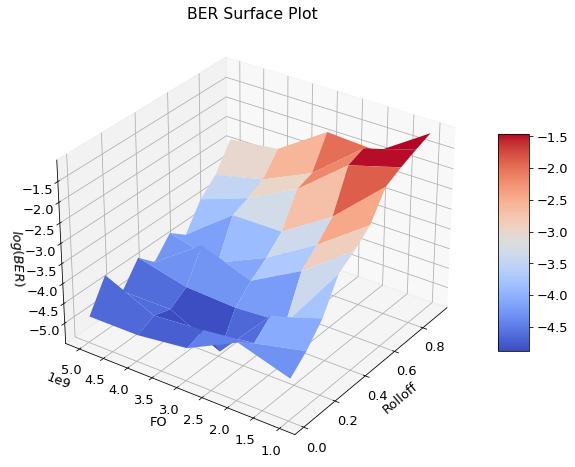

In [88]:
x = np.arange(0.01, 0.99, 0.1)
y = np.arange(1e9, 6e9, 1e9)

x, y = np.meshgrid(x, y)
z1 = np.log10(BER_NN)  # shape((5, 10))

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(x, y, z1, cmap=cm.coolwarm, linewidth=1, antialiased=True, edgecolor='None')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=7)
ax.set_xlabel('Rolloff')
ax.set_ylabel('FO')
ax.set_zlabel('$log(BER)$')
ax.view_init(elev=30, azim=215)
ax.set_title('BER Surface Plot')

plt.show()
plt.savefig(r'C:\Users\Silas João\Documents\GitHub\PIVIC-Comunicacoes-Opticas\resultados\results_ModelPerformance_64QAM.png', dpi=600)

In [2]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 64                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 600000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
#paramTx.alphaRRC = 0.91        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 50      # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16          # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
#FO = 5e9 + paramTx.Rs/2  # frequency offset
lw = 0*200e3       # linewidth
ϕ_lo = 0           # initial phase in rad
Plo_dBm = 12        # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

In [3]:
FO_Values = np.arange(1e9, 6e9, 1e9)
Rolloff = np.arange(0.01, 0.99, 0.1)

BER_KK = np.zeros((FO_Values.size, Rolloff.size))
SER_KK = np.zeros((FO_Values.size, Rolloff.size))
GMI_KK = np.zeros((FO_Values.size, Rolloff.size))
MI_KK  = np.zeros((FO_Values.size, Rolloff.size))
SNR_KK = np.zeros((FO_Values.size, Rolloff.size))

for indNN, FO_ in enumerate(FO_Values):
    for index, indRoll_ in enumerate(Rolloff):
        # Main simulation parameters
        paramTx.alphaRRC = indRoll_
        FO = FO_ + paramTx.Rs/2
        
        # generate optical signal signal
        sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

        # simulate linear signal propagation
        sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

        # receiver detection and demodulation
        Fc = paramTx.Fc
        Ts = 1 / Fs
        mod = QAMModem(m=paramTx.M)

        freqGrid = paramTx.freqGrid
        print(
            "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
            % (
                chIndex,
                (Fc + freqGrid[chIndex]) / 1e12,
                const.c / (Fc + freqGrid[chIndex]) / 1e-9,
            )
        )

        symbTx = symbTx_[:, :, chIndex]

        Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

        print(
            "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
            % (Plo_dBm, lw / 1e3, FO / 1e6)
        )

        # generate LO field
        π = np.pi
        t = np.arange(0, len(sigCh))*Ts
        ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

        sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

        # Add LO to the received signal
        sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
        sfm = sigRx.copy()

        print('CSPR = %.2f dB' % (10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

        # ### Phase-retrieval stage

        # In[4]:

        # resampling to ADC sampling rate
        sigCh = resample(sigCh, paramADC)
        sfm = resample(sfm, paramADC)
        newFs = paramADC.SpS_out*paramTx.Rs

        # simulate ideal direct-detection optical receiver
        Amp = np.abs(sigRx)
        Amp = resample(Amp, paramADC)

        # Kramers-Kronig phase-retrieval
        phiTime = KramersKronigRx(Amp, newFs)

        # optical field reconstruction
        sigRx = Amp*np.exp(1j*phiTime)

        # remove DC level
        sigRx -= np.sqrt(Plo)  # np.mean(sigRx)

        # downshift to baseband
        t = np.arange(0, len(sigRx))*(1/newFs)
        sigRx *= np.exp(-1j * (2 * π * FO * t))

        # correct for (possible) phase ambiguity
        rot = np.mean(sigCh/sigRx)
        sigRx = rot * sigRx
        sigRx = sigRx / np.sqrt(signal_power(sigRx))

        # #### Standard receiver processing

        # In[5]:

        # resample to 2 samples/symbol:
        paramRes = parameters()
        paramRes.Rs = paramTx.Rs
        paramRes.SpS_in = paramADC.SpS_out
        paramRes.SpS_out = 2

        sigRx = resample(sigRx, paramRes)

        # Matched filtering and CD compensation

        # Matched filtering
        if paramTx.pulse == "nrz":
            pulse = pulseShape("nrz", paramADC.SpS_out)
        elif paramTx.pulse == "rrc":
            pulse = pulseShape("rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs)

        pulse = pulse / np.max(np.abs(pulse))
        sigRx = firFilter(pulse, sigRx)

        # plot constellations after matched filtering
        #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

        # CD compensation
        sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

        #plot constellations after CD compensation
        #pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

        # Downsampling to 2 sps and re-synchronization with transmitted sequences
        sigRx = sigRx.reshape(-1, 1)

        symbRx = symbolSync(sigRx, symbTx, 2)

        # In[6]:

        # Power normalization
        x = sigRx
        d = symbRx

        x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
        d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

        # Adaptive equalization
        mod = QAMModem(m=paramTx.M)

        paramEq = parameters()
        paramEq.nTaps = 15
        paramEq.SpS = 2
        paramEq.mu = [5e-3, 2e-3]
        paramEq.numIter = 5
        paramEq.storeCoeff = False
        paramEq.alg = ["nlms", "dd-lms"]
        paramEq.M = paramTx.M
        paramEq.L = [20000, 80000]

        y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

        discard = int(paramEq.L[0]/2)

        #plot constellations after adaptive equalization
        #pconst(y_EQ[discard:-discard, :], lim=True)

        # In[7]:

        # Carrier phase recovery
        paramCPR = parameters()
        paramCPR.alg = "bps"
        paramCPR.M = paramTx.M
        paramCPR.N = 75
        paramCPR.B = 64
        paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

        y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

        y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

        discard = 5000

        # plot constellations after CPR
        #pconst(y_CPR[discard:-discard, :], lim=True)

        # #### Evaluate transmission metrics

        # In[8]:

        # correct for (possible) phase ambiguity
        for k in range(y_CPR.shape[1]):
            rot = np.mean(d[:, k] / y_CPR[:, k])
            y_CPR[:, k] = rot * y_CPR[:, k]

        y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

        ind = np.arange(discard, d.shape[0] - discard)
        BER_KK[indNN][index], SER_KK[indNN][index], SNR_KK[indNN][index] = fastBERcalc(y_CPR[ind, :], d[ind, :], mod)
        GMI_KK[indNN][index], _ = monteCarloGMI(y_CPR[ind, :], d[ind, :], mod)
        MI_KK[indNN][index] = monteCarloMI(y_CPR[ind, :], d[ind, :], mod)

        print("Results:\n")
        print("SER: %.2e" % (SER_KK[indNN][index]))
        print("BER: %.2e" % (BER_KK[indNN][index]))
        print("SNR: %.2f dB" % (SNR_KK[indNN][index]))
        print("MI: %.2f bits" % (MI_KK[indNN][index]))
        print("GMI: %.2f bits" % (GMI_KK[indNN][index]))


channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022166.
nlms pre-convergence training iteration #1
nlms MSE = 0.002309.
nlms pre-convergence training iteration #2
nlms MSE = 0.001904.
nlms pre-convergence training iteration #3
nlms MSE = 0.001671.
nlms pre-convergence training iteration #4
nlms MSE = 0.001518.


dd-lms - training stage #1
dd-lms MSE = 0.000988.
Results:

SER: 4.44e-04
BER: 1.17e-04
SNR: 29.83 dB
MI: 6.00 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020216.
nlms pre-convergence training iteration #1
nlms MSE = 0.002802.
nlms pre-convergence training iteration #2
nlms MSE = 0.002339.
nlms pre-convergence training iteration #3
nlms MSE = 0.002099.
nlms pre-convergence training iteration #4
nlms MSE = 0.001952.


dd-lms - training stage #1
dd-lms MSE = 0.001195.
Results:

SER: 3.89e-04
BER: 8.52e-05
SNR: 29.19 dB
MI: 5.99 bits
GMI: 5.99 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.023184.
nlms pre-convergence training iteration #1
nlms MSE = 0.005543.
nlms pre-convergence training iteration #2
nlms MSE = 0.004833.
nlms pre-convergence training iteration #3
nlms MSE = 0.004447.
nlms pre-convergence training iteration #4
nlms MSE = 0.004195.


dd-lms - training stage #1
dd-lms MSE = 0.003053.
Results:

SER: 2.02e-03
BER: 5.00e-04
SNR: 25.15 dB
MI: 5.99 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.027537.
nlms pre-convergence training iteration #1
nlms MSE = 0.008680.
nlms pre-convergence training iteration #2
nlms MSE = 0.007151.
nlms pre-convergence training iteration #3
nlms MSE = 0.006351.
nlms pre-convergence training iteration #4
nlms MSE = 0.005838.


dd-lms - training stage #1
dd-lms MSE = 0.003926.
Results:

SER: 6.63e-03
BER: 1.68e-03
SNR: 23.94 dB
MI: 5.96 bits
GMI: 5.94 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.032769.
nlms pre-convergence training iteration #1
nlms MSE = 0.011682.
nlms pre-convergence training iteration #2
nlms MSE = 0.009298.
nlms pre-convergence training iteration #3
nlms MSE = 0.008140.
nlms pre-convergence training iteration #4
nlms MSE = 0.007438.


dd-lms - training stage #1
dd-lms MSE = 0.005146.
Results:

SER: 1.34e-02
BER: 3.44e-03
SNR: 22.72 dB
MI: 5.93 bits
GMI: 5.89 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.039147.
nlms pre-convergence training iteration #1
nlms MSE = 0.014892.
nlms pre-convergence training iteration #2
nlms MSE = 0.011766.
nlms pre-convergence training iteration #3
nlms MSE = 0.010343.
nlms pre-convergence training iteration #4
nlms MSE = 0.009508.


dd-lms - training stage #1
dd-lms MSE = 0.006596.
Results:

SER: 3.24e-02
BER: 8.40e-03
SNR: 21.41 dB
MI: 5.84 bits
GMI: 5.76 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.045061.
nlms pre-convergence training iteration #1
nlms MSE = 0.018221.
nlms pre-convergence training iteration #2
nlms MSE = 0.014442.
nlms pre-convergence training iteration #3
nlms MSE = 0.012721.
nlms pre-convergence training iteration #4
nlms MSE = 0.011710.


dd-lms - training stage #1
dd-lms MSE = 0.007921.
Results:

SER: 5.31e-02
BER: 1.40e-02
SNR: 20.40 dB
MI: 5.75 bits
GMI: 5.62 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.050187.
nlms pre-convergence training iteration #1
nlms MSE = 0.021160.
nlms pre-convergence training iteration #2
nlms MSE = 0.016769.
nlms pre-convergence training iteration #3
nlms MSE = 0.014761.
nlms pre-convergence training iteration #4
nlms MSE = 0.013572.


dd-lms - training stage #1
dd-lms MSE = 0.009308.
Results:

SER: 8.27e-02
BER: 2.20e-02
SNR: 19.47 dB
MI: 5.64 bits
GMI: 5.44 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.056270.
nlms pre-convergence training iteration #1
nlms MSE = 0.025663.
nlms pre-convergence training iteration #2
nlms MSE = 0.020466.
nlms pre-convergence training iteration #3
nlms MSE = 0.017991.
nlms pre-convergence training iteration #4
nlms MSE = 0.016494.


dd-lms - training stage #1
dd-lms MSE = 0.010703.
Results:

SER: 1.18e-01
BER: 3.16e-02
SNR: 18.57 dB
MI: 5.50 bits
GMI: 5.24 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.064175.
nlms pre-convergence training iteration #1
nlms MSE = 0.029384.
nlms pre-convergence training iteration #2
nlms MSE = 0.023385.
nlms pre-convergence training iteration #3
nlms MSE = 0.020580.
nlms pre-convergence training iteration #4
nlms MSE = 0.018886.


dd-lms - training stage #1
dd-lms MSE = 0.011898.
Results:

SER: 1.64e-01
BER: 4.45e-02
SNR: 17.71 dB
MI: 5.32 bits
GMI: 4.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022316.
nlms pre-convergence training iteration #1
nlms MSE = 0.002549.
nlms pre-convergence training iteration #2
nlms MSE = 0.002150.
nlms pre-convergence training iteration #3
nlms MSE = 0.001920.
nlms pre-convergence training iteration #4
nlms MSE = 0.001767.


dd-lms - training stage #1
dd-lms MSE = 0.001105.
Results:

SER: 5.89e-04
BER: 1.37e-04
SNR: 29.36 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019985.
nlms pre-convergence training iteration #1
nlms MSE = 0.002598.
nlms pre-convergence training iteration #2
nlms MSE = 0.002128.
nlms pre-convergence training iteration #3
nlms MSE = 0.001882.
nlms pre-convergence training iteration #4
nlms MSE = 0.001731.


dd-lms - training stage #1
dd-lms MSE = 0.001021.
Results:

SER: 5.00e-04
BER: 1.22e-04
SNR: 29.73 dB
MI: 5.99 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.018129.
nlms pre-convergence training iteration #1
nlms MSE = 0.002382.
nlms pre-convergence training iteration #2
nlms MSE = 0.002175.
nlms pre-convergence training iteration #3
nlms MSE = 0.002036.
nlms pre-convergence training iteration #4
nlms MSE = 0.001936.


dd-lms - training stage #1
dd-lms MSE = 0.001474.
Results:

SER: 6.89e-04
BER: 1.89e-04
SNR: 28.24 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020042.
nlms pre-convergence training iteration #1
nlms MSE = 0.004921.
nlms pre-convergence training iteration #2
nlms MSE = 0.004331.
nlms pre-convergence training iteration #3
nlms MSE = 0.003940.
nlms pre-convergence training iteration #4
nlms MSE = 0.003660.


dd-lms - training stage #1
dd-lms MSE = 0.002293.
Results:

SER: 1.24e-03
BER: 2.91e-04
SNR: 26.31 dB
MI: 5.99 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.023853.
nlms pre-convergence training iteration #1
nlms MSE = 0.007331.
nlms pre-convergence training iteration #2
nlms MSE = 0.005814.
nlms pre-convergence training iteration #3
nlms MSE = 0.005004.
nlms pre-convergence training iteration #4
nlms MSE = 0.004511.


dd-lms - training stage #1
dd-lms MSE = 0.003119.
Results:

SER: 2.68e-03
BER: 6.57e-04
SNR: 25.01 dB
MI: 5.98 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.028439.
nlms pre-convergence training iteration #1
nlms MSE = 0.009584.
nlms pre-convergence training iteration #2
nlms MSE = 0.007390.
nlms pre-convergence training iteration #3
nlms MSE = 0.006398.
nlms pre-convergence training iteration #4
nlms MSE = 0.005844.


dd-lms - training stage #1
dd-lms MSE = 0.004194.
Results:

SER: 7.24e-03
BER: 1.79e-03
SNR: 23.68 dB
MI: 5.95 bits
GMI: 5.93 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.033798.
nlms pre-convergence training iteration #1
nlms MSE = 0.012108.
nlms pre-convergence training iteration #2
nlms MSE = 0.009355.
nlms pre-convergence training iteration #3
nlms MSE = 0.008209.
nlms pre-convergence training iteration #4
nlms MSE = 0.007578.


dd-lms - training stage #1
dd-lms MSE = 0.005519.
Results:

SER: 1.65e-02
BER: 4.28e-03
SNR: 22.40 dB
MI: 5.92 bits
GMI: 5.88 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.039857.
nlms pre-convergence training iteration #1
nlms MSE = 0.015573.
nlms pre-convergence training iteration #2
nlms MSE = 0.012106.
nlms pre-convergence training iteration #3
nlms MSE = 0.010606.
nlms pre-convergence training iteration #4
nlms MSE = 0.009755.


dd-lms - training stage #1
dd-lms MSE = 0.006762.
Results:

SER: 3.21e-02
BER: 8.22e-03
SNR: 21.32 dB
MI: 5.85 bits
GMI: 5.77 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.045171.
nlms pre-convergence training iteration #1
nlms MSE = 0.018420.
nlms pre-convergence training iteration #2
nlms MSE = 0.014350.
nlms pre-convergence training iteration #3
nlms MSE = 0.012570.
nlms pre-convergence training iteration #4
nlms MSE = 0.011539.


dd-lms - training stage #1
dd-lms MSE = 0.008198.
Results:

SER: 5.27e-02
BER: 1.37e-02
SNR: 20.33 dB
MI: 5.76 bits
GMI: 5.64 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 18000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.052344.
nlms pre-convergence training iteration #1
nlms MSE = 0.022746.
nlms pre-convergence training iteration #2
nlms MSE = 0.017804.
nlms pre-convergence training iteration #3
nlms MSE = 0.015566.
nlms pre-convergence training iteration #4
nlms MSE = 0.014235.


dd-lms - training stage #1
dd-lms MSE = 0.009352.
Results:

SER: 8.31e-02
BER: 2.19e-02
SNR: 19.43 dB
MI: 5.64 bits
GMI: 5.46 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022180.
nlms pre-convergence training iteration #1
nlms MSE = 0.002544.
nlms pre-convergence training iteration #2
nlms MSE = 0.002142.
nlms pre-convergence training iteration #3
nlms MSE = 0.001912.
nlms pre-convergence training iteration #4
nlms MSE = 0.001762.


dd-lms - training stage #1
dd-lms MSE = 0.001287.
Results:

SER: 7.67e-04
BER: 2.09e-04
SNR: 28.73 dB
MI: 5.99 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.019919.
nlms pre-convergence training iteration #1
nlms MSE = 0.002544.
nlms pre-convergence training iteration #2
nlms MSE = 0.002083.
nlms pre-convergence training iteration #3
nlms MSE = 0.001839.
nlms pre-convergence training iteration #4
nlms MSE = 0.001689.


dd-lms - training stage #1
dd-lms MSE = 0.001173.
Results:

SER: 7.00e-04
BER: 1.70e-04
SNR: 29.13 dB
MI: 5.99 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.017224.
nlms pre-convergence training iteration #1
nlms MSE = 0.002130.
nlms pre-convergence training iteration #2
nlms MSE = 0.001954.
nlms pre-convergence training iteration #3
nlms MSE = 0.001829.
nlms pre-convergence training iteration #4
nlms MSE = 0.001738.


dd-lms - training stage #1
dd-lms MSE = 0.001245.
Results:

SER: 5.78e-04
BER: 1.57e-04
SNR: 28.85 dB
MI: 5.99 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.016496.
nlms pre-convergence training iteration #1
nlms MSE = 0.002468.
nlms pre-convergence training iteration #2
nlms MSE = 0.002389.
nlms pre-convergence training iteration #3
nlms MSE = 0.002320.
nlms pre-convergence training iteration #4
nlms MSE = 0.002260.


dd-lms - training stage #1
dd-lms MSE = 0.001732.
Results:

SER: 9.11e-04
BER: 2.39e-04
SNR: 27.47 dB
MI: 5.99 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.018268.
nlms pre-convergence training iteration #1
nlms MSE = 0.004815.
nlms pre-convergence training iteration #2
nlms MSE = 0.004224.
nlms pre-convergence training iteration #3
nlms MSE = 0.003817.
nlms pre-convergence training iteration #4
nlms MSE = 0.003523.


dd-lms - training stage #1
dd-lms MSE = 0.002216.
Results:

SER: 1.20e-03
BER: 3.17e-04
SNR: 26.40 dB
MI: 5.99 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022144.
nlms pre-convergence training iteration #1
nlms MSE = 0.006872.
nlms pre-convergence training iteration #2
nlms MSE = 0.005430.
nlms pre-convergence training iteration #3
nlms MSE = 0.004665.
nlms pre-convergence training iteration #4
nlms MSE = 0.004220.


dd-lms - training stage #1
dd-lms MSE = 0.002947.
Results:

SER: 2.46e-03
BER: 6.31e-04
SNR: 25.25 dB
MI: 5.98 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.026502.
nlms pre-convergence training iteration #1
nlms MSE = 0.008769.
nlms pre-convergence training iteration #2
nlms MSE = 0.006660.
nlms pre-convergence training iteration #3
nlms MSE = 0.005758.
nlms pre-convergence training iteration #4
nlms MSE = 0.005294.


dd-lms - training stage #1
dd-lms MSE = 0.003968.
Results:

SER: 5.91e-03
BER: 1.47e-03
SNR: 23.95 dB
MI: 5.96 bits
GMI: 5.95 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.030162.
nlms pre-convergence training iteration #1
nlms MSE = 0.011073.
nlms pre-convergence training iteration #2
nlms MSE = 0.008365.
nlms pre-convergence training iteration #3
nlms MSE = 0.007246.
nlms pre-convergence training iteration #4
nlms MSE = 0.006661.


dd-lms - training stage #1
dd-lms MSE = 0.005166.
Results:

SER: 1.40e-02
BER: 3.57e-03
SNR: 22.72 dB
MI: 5.93 bits
GMI: 5.89 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.035327.
nlms pre-convergence training iteration #1
nlms MSE = 0.013923.
nlms pre-convergence training iteration #2
nlms MSE = 0.010700.
nlms pre-convergence training iteration #3
nlms MSE = 0.009344.
nlms pre-convergence training iteration #4
nlms MSE = 0.008591.


dd-lms - training stage #1
dd-lms MSE = 0.006272.
Results:

SER: 2.57e-02
BER: 6.61e-03
SNR: 21.70 dB
MI: 5.87 bits
GMI: 5.81 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.042201.
nlms pre-convergence training iteration #1
nlms MSE = 0.017384.
nlms pre-convergence training iteration #2
nlms MSE = 0.013584.
nlms pre-convergence training iteration #3
nlms MSE = 0.011956.
nlms pre-convergence training iteration #4
nlms MSE = 0.011011.


dd-lms - training stage #1
dd-lms MSE = 0.007374.
Results:

SER: 4.39e-02
BER: 1.15e-02
SNR: 20.75 dB
MI: 5.79 bits
GMI: 5.69 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.023135.
nlms pre-convergence training iteration #1
nlms MSE = 0.002822.
nlms pre-convergence training iteration #2
nlms MSE = 0.002418.
nlms pre-convergence training iteration #3
nlms MSE = 0.002186.
nlms pre-convergence training iteration #4
nlms MSE = 0.002033.


dd-lms - training stage #1
dd-lms MSE = 0.001489.
Results:

SER: 1.09e-03
BER: 2.69e-04
SNR: 28.07 dB
MI: 5.98 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020203.
nlms pre-convergence training iteration #1
nlms MSE = 0.002937.
nlms pre-convergence training iteration #2
nlms MSE = 0.002470.
nlms pre-convergence training iteration #3
nlms MSE = 0.002223.
nlms pre-convergence training iteration #4
nlms MSE = 0.002071.


dd-lms - training stage #1
dd-lms MSE = 0.001367.
Results:

SER: 8.11e-04
BER: 2.17e-04
SNR: 28.46 dB
MI: 5.98 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.017431.
nlms pre-convergence training iteration #1
nlms MSE = 0.002595.
nlms pre-convergence training iteration #2
nlms MSE = 0.002411.
nlms pre-convergence training iteration #3
nlms MSE = 0.002281.
nlms pre-convergence training iteration #4
nlms MSE = 0.002187.


dd-lms - training stage #1
dd-lms MSE = 0.001478.
Results:

SER: 1.09e-03
BER: 2.56e-04
SNR: 28.13 dB
MI: 5.98 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015844.
nlms pre-convergence training iteration #1
nlms MSE = 0.002218.
nlms pre-convergence training iteration #2
nlms MSE = 0.002186.
nlms pre-convergence training iteration #3
nlms MSE = 0.002156.
nlms pre-convergence training iteration #4
nlms MSE = 0.002130.


dd-lms - training stage #1
dd-lms MSE = 0.001665.
Results:

SER: 1.11e-03
BER: 2.70e-04
SNR: 27.68 dB
MI: 5.98 bits
GMI: 5.98 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015372.
nlms pre-convergence training iteration #1
nlms MSE = 0.003136.
nlms pre-convergence training iteration #2
nlms MSE = 0.003020.
nlms pre-convergence training iteration #3
nlms MSE = 0.002918.
nlms pre-convergence training iteration #4
nlms MSE = 0.002828.


dd-lms - training stage #1
dd-lms MSE = 0.002048.
Results:

SER: 1.62e-03
BER: 4.22e-04
SNR: 26.71 dB
MI: 5.98 bits
GMI: 5.96 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.017529.
nlms pre-convergence training iteration #1
nlms MSE = 0.004994.
nlms pre-convergence training iteration #2
nlms MSE = 0.004383.
nlms pre-convergence training iteration #3
nlms MSE = 0.003950.
nlms pre-convergence training iteration #4
nlms MSE = 0.003633.


dd-lms - training stage #1
dd-lms MSE = 0.002495.
Results:

SER: 2.36e-03
BER: 6.07e-04
SNR: 25.84 dB
MI: 5.98 bits
GMI: 5.96 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.021252.
nlms pre-convergence training iteration #1
nlms MSE = 0.007070.
nlms pre-convergence training iteration #2
nlms MSE = 0.005684.
nlms pre-convergence training iteration #3
nlms MSE = 0.004912.
nlms pre-convergence training iteration #4
nlms MSE = 0.004457.


dd-lms - training stage #1
dd-lms MSE = 0.003133.
Results:

SER: 3.67e-03
BER: 9.33e-04
SNR: 24.89 dB
MI: 5.97 bits
GMI: 5.96 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.025289.
nlms pre-convergence training iteration #1
nlms MSE = 0.009089.
nlms pre-convergence training iteration #2
nlms MSE = 0.006950.
nlms pre-convergence training iteration #3
nlms MSE = 0.005994.
nlms pre-convergence training iteration #4
nlms MSE = 0.005505.


dd-lms - training stage #1
dd-lms MSE = 0.004099.
Results:

SER: 7.11e-03
BER: 1.77e-03
SNR: 23.76 dB
MI: 5.95 bits
GMI: 5.93 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.029347.
nlms pre-convergence training iteration #1
nlms MSE = 0.011106.
nlms pre-convergence training iteration #2
nlms MSE = 0.008428.
nlms pre-convergence training iteration #3
nlms MSE = 0.007345.
nlms pre-convergence training iteration #4
nlms MSE = 0.006794.


dd-lms - training stage #1
dd-lms MSE = 0.005137.
Results:

SER: 1.36e-02
BER: 3.45e-03
SNR: 22.69 dB
MI: 5.93 bits
GMI: 5.89 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.034547.
nlms pre-convergence training iteration #1
nlms MSE = 0.014007.
nlms pre-convergence training iteration #2
nlms MSE = 0.010773.
nlms pre-convergence training iteration #3
nlms MSE = 0.009450.
nlms pre-convergence training iteration #4
nlms MSE = 0.008734.


dd-lms - training stage #1
dd-lms MSE = 0.006195.
Results:

SER: 2.49e-02
BER: 6.35e-03
SNR: 21.74 dB
MI: 5.88 bits
GMI: 5.82 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.022838.
nlms pre-convergence training iteration #1
nlms MSE = 0.003166.
nlms pre-convergence training iteration #2
nlms MSE = 0.002737.
nlms pre-convergence training iteration #3
nlms MSE = 0.002494.
nlms pre-convergence training iteration #4
nlms MSE = 0.002333.


dd-lms - training stage #1
dd-lms MSE = 0.001698.
Results:

SER: 1.47e-03
BER: 3.65e-04
SNR: 27.46 dB
MI: 5.98 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020421.
nlms pre-convergence training iteration #1
nlms MSE = 0.003107.
nlms pre-convergence training iteration #2
nlms MSE = 0.002635.
nlms pre-convergence training iteration #3
nlms MSE = 0.002386.
nlms pre-convergence training iteration #4
nlms MSE = 0.002233.


dd-lms - training stage #1
dd-lms MSE = 0.001637.
Results:

SER: 1.37e-03
BER: 3.43e-04
SNR: 27.64 dB
MI: 5.97 bits
GMI: 5.95 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.018366.
nlms pre-convergence training iteration #1
nlms MSE = 0.002832.
nlms pre-convergence training iteration #2
nlms MSE = 0.002649.
nlms pre-convergence training iteration #3
nlms MSE = 0.002521.
nlms pre-convergence training iteration #4
nlms MSE = 0.002427.


dd-lms - training stage #1
dd-lms MSE = 0.001712.
Results:

SER: 1.27e-03
BER: 3.24e-04
SNR: 27.46 dB
MI: 5.98 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.016049.
nlms pre-convergence training iteration #1
nlms MSE = 0.002240.
nlms pre-convergence training iteration #2
nlms MSE = 0.002204.
nlms pre-convergence training iteration #3
nlms MSE = 0.002172.
nlms pre-convergence training iteration #4
nlms MSE = 0.002143.


dd-lms - training stage #1
dd-lms MSE = 0.001818.
Results:

SER: 1.23e-03
BER: 3.17e-04
SNR: 27.27 dB
MI: 5.98 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.015129.
nlms pre-convergence training iteration #1
nlms MSE = 0.002837.
nlms pre-convergence training iteration #2
nlms MSE = 0.002794.
nlms pre-convergence training iteration #3
nlms MSE = 0.002754.
nlms pre-convergence training iteration #4
nlms MSE = 0.002716.


dd-lms - training stage #1
dd-lms MSE = 0.002029.
Results:

SER: 1.70e-03
BER: 4.13e-04
SNR: 26.77 dB
MI: 5.98 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.016085.
nlms pre-convergence training iteration #1
nlms MSE = 0.003953.
nlms pre-convergence training iteration #2
nlms MSE = 0.003800.
nlms pre-convergence training iteration #3
nlms MSE = 0.003665.
nlms pre-convergence training iteration #4
nlms MSE = 0.003546.


dd-lms - training stage #1
dd-lms MSE = 0.002429.
Results:

SER: 2.18e-03
BER: 5.43e-04
SNR: 25.97 dB
MI: 5.98 bits
GMI: 5.97 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.017438.
nlms pre-convergence training iteration #1
nlms MSE = 0.005429.
nlms pre-convergence training iteration #2
nlms MSE = 0.004837.
nlms pre-convergence training iteration #3
nlms MSE = 0.004408.
nlms pre-convergence training iteration #4
nlms MSE = 0.004093.


dd-lms - training stage #1
dd-lms MSE = 0.002933.
Results:

SER: 3.61e-03
BER: 8.50e-04
SNR: 25.15 dB
MI: 5.96 bits
GMI: 5.94 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.020351.
nlms pre-convergence training iteration #1
nlms MSE = 0.007387.
nlms pre-convergence training iteration #2
nlms MSE = 0.006112.
nlms pre-convergence training iteration #3
nlms MSE = 0.005383.
nlms pre-convergence training iteration #4
nlms MSE = 0.004947.


dd-lms - training stage #1
dd-lms MSE = 0.003605.
Results:

SER: 5.28e-03
BER: 1.39e-03
SNR: 24.31 dB
MI: 5.96 bits
GMI: 5.94 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.023116.
nlms pre-convergence training iteration #1
nlms MSE = 0.009072.
nlms pre-convergence training iteration #2
nlms MSE = 0.007192.
nlms pre-convergence training iteration #3
nlms MSE = 0.006316.
nlms pre-convergence training iteration #4
nlms MSE = 0.005856.


dd-lms - training stage #1
dd-lms MSE = 0.004480.
Results:

SER: 8.76e-03
BER: 2.28e-03
SNR: 23.32 dB
MI: 5.94 bits
GMI: 5.91 bits
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.027704.
nlms pre-convergence training iteration #1
nlms MSE = 0.011237.
nlms pre-convergence training iteration #2
nlms MSE = 0.008761.
nlms pre-convergence training iteration #3
nlms MSE = 0.007726.
nlms pre-convergence training iteration #4
nlms MSE = 0.007188.


dd-lms - training stage #1
dd-lms MSE = 0.005393.
Results:

SER: 1.47e-02
BER: 3.70e-03
SNR: 22.47 dB
MI: 5.92 bits
GMI: 5.89 bits


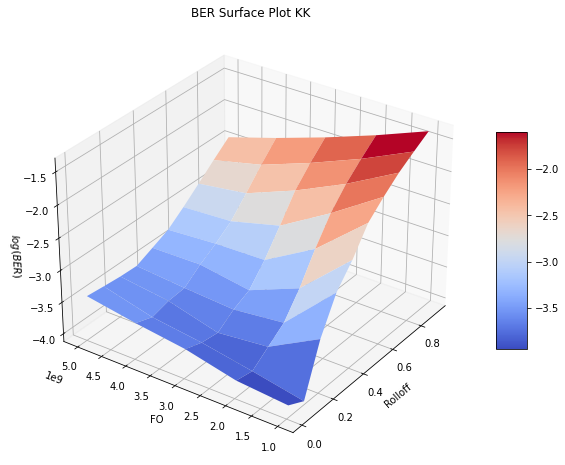

<Figure size 432x288 with 0 Axes>

In [8]:
x = np.arange(0.01, 0.99, 0.1)
y = np.arange(1e9, 6e9, 1e9)

x, y = np.meshgrid(x, y)
z1 = np.log10(BER_KK)  # shape((5, 10))

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf_KK = ax.plot_surface(x, y, z1, cmap=cm.coolwarm, linewidth=1, antialiased=True, edgecolor='None')
fig.colorbar(surf_KK, ax=ax, shrink=0.5, aspect=7)
ax.set_xlabel('Rolloff')
ax.set_ylabel('FO')
ax.set_zlabel('$log(BER)$')
ax.view_init(elev=30, azim=215)
ax.set_title('BER Surface Plot KK')

plt.show()
plt.savefig(r'C:\Users\Silas João\Documents\GitHub\PIVIC-Comunicacoes-Opticas\resultados\results_KKPerformance_64QAM.png', dpi=600)
